<a href="https://colab.research.google.com/github/raulbenitez/DEEPCARDIO/blob/master/sparks/train/inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive") # , force_remount=True)

Mounted at /content/drive


# Imports and useful functions

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as kb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Insert the directory
import sys
sys.path.insert(0, 'drive/MyDrive/tfm/DEEPCARDIO_drive/sparks')
# ! ls drive/MyDrive/tfm/DEEPCARDIO_drive/sparks/train

from train.inception import load_data, _recall_and_false_spark, sigmoid_spark_and_non_spark_loss, _sigmoid, sigmoid_loss

filesPath = 'drive/MyDrive/tfm/DEEPCARDIO_drive/sparks/train/'


def evaluate_prediction(trainId, X, Y):
  inceptionv3 = keras.applications.InceptionV3(include_top=True, weights=None, classes=2, input_shape=X_train[0].shape)
  inceptionv3.load_weights(f"drive/MyDrive/tfm/DEEPCARDIO_drive/sparks/train/{trainId}.h5")

  class_labels = ['no-spark', 'spark']

  Y_pred = inceptionv3.predict(X)
  Y_pred = Y_pred.round()

  confMatrix = confusion_matrix(Y.argmax(axis=1), Y_pred.argmax(axis=1), normalize='true')
  plt.figure(figsize=(10,8))
  sns.heatmap(confMatrix, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot=True)
  plt.title('confusion matrix')
  plt.xlabel('predicted')
  plt.ylabel('true')
  plt.show()
  print("Classification report validation:\n",  classification_report(Y.argmax(axis=1), Y_pred.argmax(axis=1), target_names=class_labels))

  return Y_pred

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
! rm -r logs

rm: cannot remove 'logs': No such file or directory


# Data read

In [ ]:
trainData = '2021-02-03_23-53-32_synthetic' # 2021-01-23_02-02-14_gen_images, 2021-02-03_23-53-32_synthetic

# X_train, Y_train, X_test, Y_test = load_data(classesFromFile=True, imageFolder='drive/MyDrive/tfm/DEEPCARDIO_drive/_datasets/deepcardio/170215_RyR-GFP30_RO_01_Serie2_SPARKS-calcium', gaussianFilter=False)
X_train, Y_train, X_test, Y_test = load_data(classesFromFile=True, imageId=trainData,  # 170215_RyR-GFP30_RO_01_Serie2_SPARKS-calcium', 
                                             datasetsPath='drive/MyDrive/tfm/DEEPCARDIO_drive/_datasets/deepcardio/', gaussianFilter=False)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

weight_array = compute_class_weight('balanced', np.unique(Y_train), Y_train.argmax(axis=-1))
weight_dict = dict(zip(np.unique(Y_train), weight_array))
weight_dict

Prop of sparks in train dataset: 6.88, and in validation dataset: 6.88


{0.0: 0.5366126327557295, 1.0: 7.32824427480916}

# Train

trainId: borrar_inceptionv3_ep30_b32__learn0.00001__2021-02-03_23-53-32_synthetic
Epoch 1/30
62/62 [==============================] - 16s 161ms/step - loss: 0.6770 - accuracy: 0.8166 - val_loss: 0.2600 - val_accuracy: 0.9292
Epoch 2/30
62/62 [==============================] - 8s 122ms/step - loss: 0.2678 - accuracy: 0.8911 - val_loss: 0.3479 - val_accuracy: 0.9292
Epoch 3/30
62/62 [==============================] - 8s 123ms/step - loss: 0.2028 - accuracy: 0.9244 - val_loss: 0.2973 - val_accuracy: 0.9292
Epoch 4/30
62/62 [==============================] - 8s 124ms/step - loss: 0.1240 - accuracy: 0.9464 - val_loss: 0.6554 - val_accuracy: 0.9292
Epoch 5/30
62/62 [==============================] - 8s 125ms/step - loss: 0.1424 - accuracy: 0.9528 - val_loss: 2.9558 - val_accuracy: 0.0708
Epoch 6/30
62/62 [==============================] - 8s 125ms/step - loss: 0.1961 - accuracy: 0.9247 - val_loss: 0.3729 - val_accuracy: 0.9307
Epoch 7/30
62/62 [==============================] - 8s 129ms/step

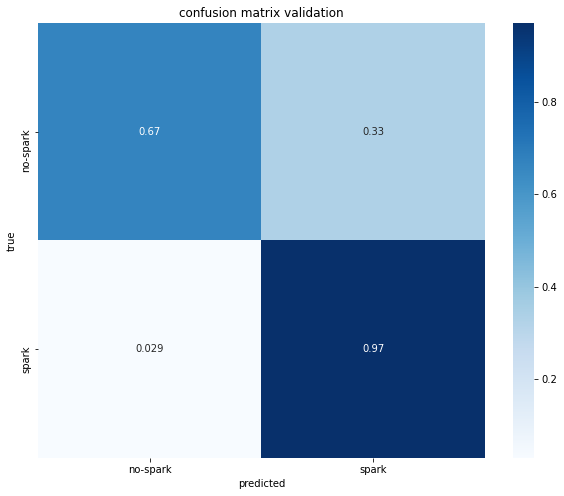

Classification report validation:
               precision    recall  f1-score   support

    no-spark       1.00      0.67      0.80      1784
       spark       0.18      0.97      0.31       136

    accuracy                           0.69      1920
   macro avg       0.59      0.82      0.55      1920
weighted avg       0.94      0.69      0.77      1920



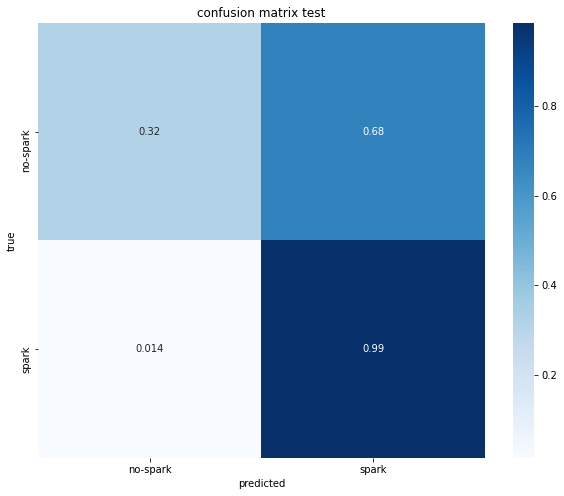

Classification report test:
               precision    recall  f1-score   support

    no-spark       0.99      0.32      0.48       421
       spark       0.20      0.99      0.33        72

    accuracy                           0.42       493
   macro avg       0.60      0.65      0.41       493
weighted avg       0.88      0.42      0.46       493



In [ ]:
# Inception V3
modelv3 = keras.applications.InceptionV3(include_top=True, weights=None, classes=2, input_shape=X_train[0].shape)
# modelv3.summary()

batch_size = 32
epochs = 30

# custom functions
loss_function = 'categorical_crossentropy' # sigmoid_loss
loss_function_str = loss_function.__name__ if not isinstance(loss_function, str) else loss_function
# recallRatio = 0.6
# metric_function = _recall_and_false_spark(recallRatio)

trainID = f"borrar_inceptionv3_ep{epochs}_b{batch_size}__learn0.00001__"+trainData
print('trainId: '+trainID)

opt = keras.optimizers.RMSprop(learning_rate=0.00001)
modelv3.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

modelv3.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_valid), shuffle=True, callbacks=[tensorboard_callback]) # , class_weight=weight_dict 

modelv3.save(f"{filesPath}{trainID}.h5")

# validation

class_labels = ['no-spark', 'spark']

Y_test_pred = modelv3.predict(X_test)
Y_valid_pred = modelv3.predict(X_valid)

confMatrix = confusion_matrix(Y_valid.argmax(axis=1), Y_valid_pred.argmax(axis=1), normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(confMatrix, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.title('confusion matrix validation')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()
print("Classification report validation:\n",  classification_report(Y_valid.argmax(axis=1), Y_valid_pred.argmax(axis=1), target_names=class_labels))

confMatrix = confusion_matrix(Y_test.argmax(axis=1), Y_test_pred.argmax(axis=1), normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(confMatrix, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.title('confusion matrix test')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()
print("Classification report test:\n",  classification_report(Y_test.argmax(axis=1), Y_test_pred.argmax(axis=1), target_names=class_labels))

In [ ]:
%tensorboard --logdir logs/fit

# Test

Prop of sparks in train dataset: 14.92, and in validation dataset: 14.6


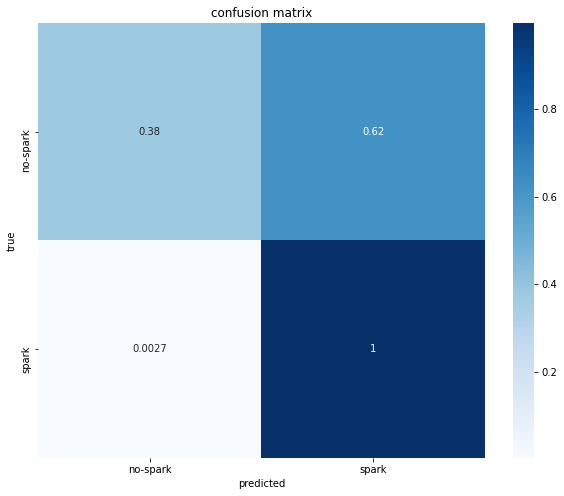

Classification report validation:
               precision    recall  f1-score   support

    no-spark       1.00      0.38      0.55      2098
       spark       0.22      1.00      0.36       366

    accuracy                           0.47      2464
   macro avg       0.61      0.69      0.45      2464
weighted avg       0.88      0.47      0.52      2464



In [ ]:
# ../../_datasets/deepcardio/170215_RyR-GFP30_RO_01_Serie2_SPARKS-calcium
X_train, Y_train, X_test, Y_test = load_data(classesFromFile=True, imageId='170215_RyR-GFP30_RO_01_Serie2_SPARKS-calcium', 
                                             datasetsPath='drive/MyDrive/tfm/DEEPCARDIO_drive/_datasets/deepcardio/', gaussianFilter=False)
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))

Y_pred = evaluate_prediction(trainID, X, Y)

Prop of sparks in train dataset: 14.92, and in validation dataset: 14.6


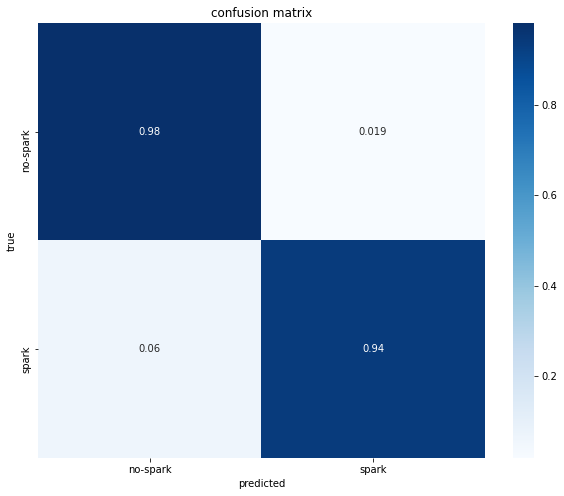

Classification report validation:
               precision    recall  f1-score   support

    no-spark       0.99      0.98      0.99      2098
       spark       0.90      0.94      0.92       366

    accuracy                           0.98      2464
   macro avg       0.94      0.96      0.95      2464
weighted avg       0.98      0.98      0.98      2464



In [ ]:
# ../../_datasets/deepcardio/170215_RyR-GFP30_RO_01_Serie2_SPARKS-calcium
X_train, Y_train, X_test, Y_test = load_data(classesFromFile=True, imageId='170215_RyR-GFP30_RO_01_Serie2_SPARKS-calcium', 
                                             datasetsPath='drive/MyDrive/tfm/DEEPCARDIO_drive/_datasets/deepcardio/', gaussianFilter=False)
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))

Y_pred = evaluate_prediction('inceptionv3_ep25_b32__2021-02-03_23-53-32_synthetic_RECALL94', X, Y)

Prop of sparks in train dataset: 6.12, and in validation dataset: 8.75


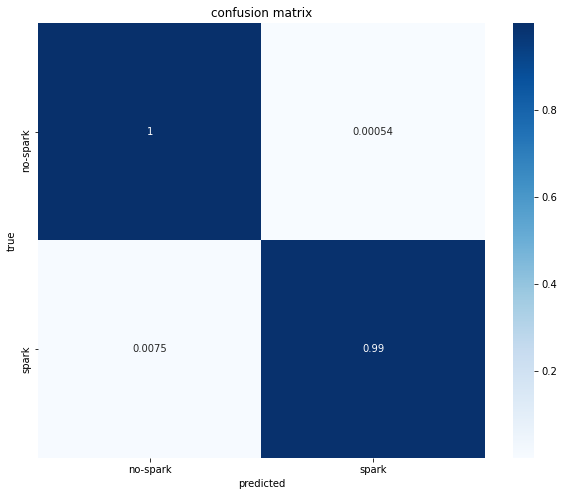

Classification report validation:
               precision    recall  f1-score   support

    no-spark       1.00      1.00      1.00      1867
       spark       0.99      0.99      0.99       133

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
# ../../_datasets/deepcardio/170215_RyR-GFP30_RO_01_Serie2_SPARKS-calcium
X_train, Y_train, X_test, Y_test = load_data(classesFromFile=True, imageId='2021-01-23_02-52-32_gen_images', 
                                             datasetsPath='drive/MyDrive/tfm/DEEPCARDIO_drive/_datasets/deepcardio/', gaussianFilter=False)
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))

Y_pred = evaluate_prediction(trainID+'_RECALL94', X, Y)

## old

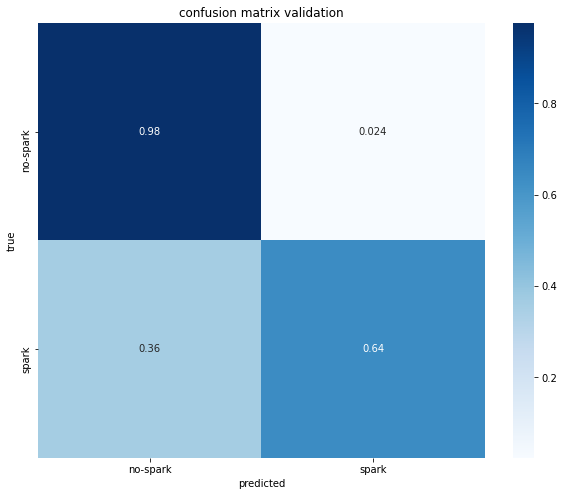

Classification report validation:
               precision    recall  f1-score   support

    no-spark       0.94      0.98      0.96       334
       spark       0.83      0.64      0.72        61

    accuracy                           0.92       395
   macro avg       0.88      0.81      0.84       395
weighted avg       0.92      0.92      0.92       395



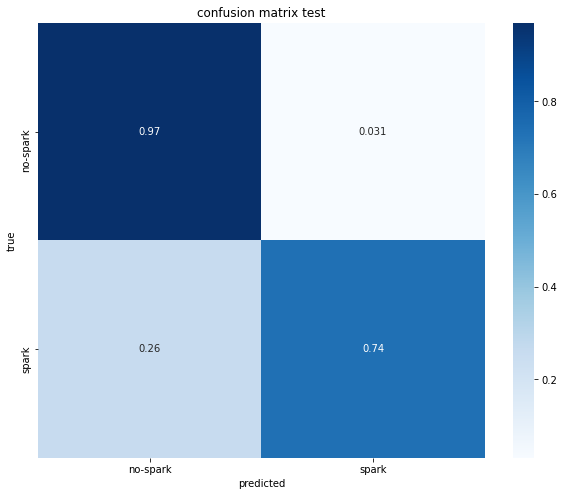

Classification report test:
               precision    recall  f1-score   support

    no-spark       0.96      0.97      0.96       421
       spark       0.80      0.74      0.77        72

    accuracy                           0.94       493
   macro avg       0.88      0.85      0.87       493
weighted avg       0.93      0.94      0.93       493



In [ ]:
class_labels = ['no-spark', 'spark']

Y_test_pred = modelv3.predict(X_test)
Y_valid_pred = modelv3.predict(X_valid)

confMatrix = confusion_matrix(Y_valid.argmax(axis=1), Y_valid_pred.argmax(axis=1), normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(confMatrix, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.title('confusion matrix validation')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()
print("Classification report validation:\n",  classification_report(Y_valid.argmax(axis=1), Y_valid_pred.argmax(axis=1), target_names=class_labels))

confMatrix = confusion_matrix(Y_test.argmax(axis=1), Y_test_pred.argmax(axis=1), normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(confMatrix, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot=True)
plt.title('confusion matrix test')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()
print("Classification report test:\n",  classification_report(Y_test.argmax(axis=1), Y_test_pred.argmax(axis=1), target_names=class_labels))

KeyError: ignored

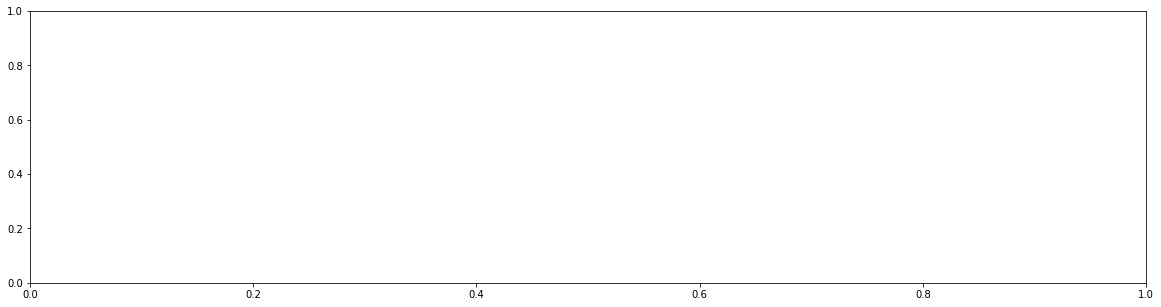

In [ ]:
# plt.figure(figsize=(20, 5))
# plt.plot(modelv3.history.history[f"{metric_function.__name__}"])
# plt.plot(modelv3.history.history[f"val_{metric_function.__name__}"])
# plt.legend(['train', 'valid'])
# plt.savefig(f"{filesPath}{trainID}_metrics.png")
# plt.show()

plt.figure(figsize=(20, 5))
plt.ylim(plt.ylim()[0], 1.0)
plt.plot(modelv3.history.history['loss'])
plt.plot(modelv3.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.savefig(f"{filesPath}{trainID}_loss.png")
plt.show()